<a href="https://colab.research.google.com/github/sheng-999/Stats_test/blob/upload/Predict_Greenweez_turnover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instagram likes prediction

We would like to predict the Greenweez turnover based on its past values

➡️ We have access to the sales from 2019 to 2021.

## Load data

a) Execute the cell below to load the data into `df` variable.

What does this SQL query do?

In [3]:
from google.colab import auth
import pandas as pd

auth.authenticate_user()

query = '''SELECT
              DATE_TRUNC(date_date, day) AS day,
              SUM(turnover) as turnover
           FROM `data-analytics-bootcamp-363212.raw_gwz.sales`
           GROUP BY day
           ORDER by day'''

df = pd.read_gbq(query, project_id="data-analytics-bootcamp-363212")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   day       1096 non-null   dbdate 
 1   turnover  1096 non-null   float64
dtypes: dbdate(1), float64(1)
memory usage: 17.2 KB


In [4]:
df['day'] = pd.to_datetime(df['day'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   day       1096 non-null   datetime64[ns]
 1   turnover  1096 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.2 KB




*   The daily sales from 2019-01-01 to 2021-12-31.




b) Plot turnover overtime using `plotly.express`.

Do you see any seasonality?

In [6]:
import plotly.express as px

In [7]:
px.line(df,
        x='day',
        y='turnover',
        title = 'Turnover over time'
        )

We can detect seasonality on this time serie: turnover drops at the end of each year.

We will try to predict the last month on December based on previous data.

## Using ARIMA model

a) Execute cell below to install missing packages

In [8]:
!pip install sktime -q
!pip install pmdarima -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.6 MB/s eta 0:00:00


b) Let's keep the last month on December 2021 as the test set to evaluate our prediction. We will set `test_size` parameter to 30.

You can use pandas functions or `temporal_train_test_split` from `sktime.forecasting.model_selection` to split our data into train and test.

Name them `df_train` and `df_test`


In [9]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
import numpy as np

In [10]:
df_train, df_test = temporal_train_test_split(
    df,
    test_size= 30
)
df_train.shape, df_test.shape

((1066, 2), (30, 2))

c) AutoARIMA is a module to search for best parameters and will fit to the best model. Use this model to fit your training data.

In [11]:
arima = AutoARIMA()
# define horizon
arima.fit(df_train['turnover'])

AutoARIMA()

d) Plot the `arima.summary()` to check the best parameters.

What is the model obtained?

In [12]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1066
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -12015.955
Date:                Tue, 22 Aug 2023   AIC                          24037.911
Time:                        17:11:19   BIC                          24052.823
Sample:                             0   HQIC                         24043.561
                               - 1066                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4044      0.021    -18.922      0.000      -0.446      -0.363
ma.L2         -0.3749      0.026    -14.566      0.000      -0.425      -0.324
sigma2      3.658e+08   1.62e-11   2.26e+19      0.000    3.66e+08    3.66e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2032.74
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                             1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.53e+34. Standard errors may be unstable.
"""

e) Our model is now ready to make a forecast using the method `predict`.
Assign the prediction for the df_test to a `pred_arima` variable.

<details>
    <summary><i>Hint</i></summary>
`predict` method accepts a forecast horizon like [1,2,3,4,5,6...]. If you want to predict 30 days, make it 30 with range function!
</details>

In [ ]:
preds = arima.predict(fh=range(1,31))
preds

In [14]:
from statsmodels.tsa.statespace import sarimax

f) Let's add the prediction to the `df_test` dataset as a new column `pred_arima`

In [15]:
df_test['pred_arima'] = preds

In [ ]:
df_test

g) Using Plotly express `px.line()`, plot turnover and predicted turnover. Do you think the model is a good one?

You can pass `df_test.set_index(day)` directly to the function. This way you don't need add_trace.

In [17]:
px.line( df_test.set_index('day'))
# we only have 2 variables, when we set index as day. The figure comes out

h) The metric **Mean Absolute Percentage Error (MAPE)** is used to compare performance on time series.
This metric is the one used by the method `score`. Assign it to the variable `score_arima`.

Is this metric better if it's bigger or smaller?

In [18]:
from sklearn.metrics import mean_absolute_percentage_error

# mean_absolute_percentage_error(y_true, y_pred)

In [26]:
# score_arima = mean_absolute_percentage_error(df_test['turnover'], df_test['pred_arima'])
score_arima=arima.score(df_test['turnover'])
print(f'MAPE score is {score_arima}')

MAPE score is 0.8828367550152308


Arima model needs to be tuned to perform better.

## Using PROPHET model

a) Start by installing greykite library on Colab.

For that, execute the cell below.

In [20]:
!pip install greykite -q
!pip install holidays==0.24

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.9/499.9 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1.4 requires holidays>=0.25, but you have holidays 0.24 which is incompatible.


b) Import the libraries

In [21]:
import datetime

from greykite.framework.templates.autogen.forecast_config import ForecastConfig, MetadataParam, ModelComponentsParam
from greykite.framework.templates.forecaster import Forecaster

c) We want to use the PROPHET model from Facebook to train our model and make a prediction for future turnover.

We want to use the same trainning values than our first ARIMA model (values until 1st Dec 2021) and test our prediction with the same values (month of December 2021).

Create a forecastconfig in a `config` variable with correct parameters. See today's lesson for the syntax.

<details>
    <summary><i>Solution:</i></summary>
    
`config = ForecastConfig(
     metadata_param=MetadataParam(
      time_col = "day",
      value_col = "turnover",
      freq="D",
      train_end_date = datetime.datetime(2021, 12, 1)),
     model_template="PROPHET",
     forecast_horizon=30,
     coverage=0.95)`
</details>

In [22]:
config = ForecastConfig(
     metadata_param=MetadataParam(
         time_col = 'day',
         value_col = 'turnover',
         freq= 'D',
         train_end_date = datetime.datetime(2021,12,1)),
     model_template="PROPHET",
     forecast_horizon= 30,
     coverage=0.95)

d) Train your model.

See today's lesson for the syntax.

In [23]:
forecast = Forecaster()
result = forecast.run_forecast_config(df=df, config=config)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


DEBUG:cmdstanpy:input tempfile: /tmp/tmpzfi7dtms/uekzqpms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzfi7dtms/9lq4erk2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87734', 'data', 'file=/tmp/tmpzfi7dtms/uekzqpms.json', 'init=/tmp/tmpzfi7dtms/9lq4erk2.json', 'output', 'file=/tmp/tmpzfi7dtms/prophet_modelu6myoaet/prophet_model-20230822171147.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:11:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzfi7dtms/2gp90oqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzfi7dtms/aq8y1ek2.json
DEBUG:cmdstanpy

e) We can access the result of the prediction with `result.forecast` and we can evaluate the performance with `result.forecast.test_evalution`.

Find the same metric as the Arima model and assign it to a `score_prophet` variable. Is this model better than ARIMA?

In [29]:
score_prophet = result.forecast.test_evaluation['MAPE']
score_prophet

# 31 is better than 0.88

31.526405591753775

f) The Greykite library has its own plot function which incorporates the upper and lower bounds of the prediction.

Don't forget that you can zoom in on the graph. Run the cell below to see the results!

In [30]:
result.forecast.plot()

## Using custom PROPHET model

g) The Facebook Prophet model allows us to integrate holidays and seasonality to the algorithm.
Try to query the table `sales` in BigQuery to find out in which country the higher number of sales is made.
In the model we will integrate the holidays of the country in which the most sales were made
Do not erase your `df` dataset, choose another name!

In [31]:
query = '''
  SELECT
   country,
              count(*) as sum_sales
           FROM `data-analytics-bootcamp-363212.raw_gwz.sales`
           GROUP BY country
           ORDER by SUM(turnover) desc
           limit 3
'''
country_sales = pd.read_gbq(query, project_id="data-analytics-bootcamp-363212")
country_sales

,country,sum_sales
0,FRANCE,8591471
1,BELGIQUE,162452
2,None,12370


h)
We will need a new `ForecastConfig`. Copy the `ForecastConfig` you made before, and add a new argument inside ForecastConfig() called `model_components_param=`. Its value should be a `ModelComponentsParam()` with:

- `seasonality = { your_code_here }`
- `events = { your_code_here })`

See your lecture for correct syntax

<details>
    <summary><i>Hint for seasonality</i></summary>
We understand from plotting the data that we have yearly seasonality. Set the `yearly_seasonality` to `True`
</details>        

In [32]:
config_holidays = ForecastConfig(
    metadata_param = MetadataParam(
      time_col = "day",
      value_col = "turnover",
      train_end_date = datetime.datetime(2021, 12, 1)),
    model_template = "PROPHET",
    forecast_horizon = 30,
    coverage = 0.95,
    model_components_param = ModelComponentsParam(
     seasonality={"yearly_seasonality": True},
     events = {
         "holiday_lookup_countries": ["France", "Belgium", "Switzerland"],
         "holiday_pre_num_days": [0],
         "holiday_post_num_days": [0],
     }))

i) Train a new facebook prophet model from this new configuration and store it in `result_custom` variable.

In [33]:
result_custom = Forecaster().run_forecast_config(df = df, config= config_holidays)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzfi7dtms/62_gpndf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzfi7dtms/japuaku8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76467', 'data', 'file=/tmp/tmpzfi7dtms/62_gpndf.json', 'init=/tmp/tmpzfi7dtms/japuaku8.json', 'output', 'file=/tmp/tmpzfi7dtms/prophet_modeldp8zaj0o/prophet_model-20230822172231.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:22:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fitting 3 folds for each of 1 candidates, totalling 3 fits


17:22:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzfi7dtms/xdo1v1cy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzfi7dtms/bsa6sia6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51979', 'data', 'file=/tmp/tmpzfi7dtms/xdo1v1cy.json', 'init=/tmp/tmpzfi7dtms/bsa6sia6.json', 'output', 'file=/tmp/tmpzfi7dtms/prophet_model8qvxu9c6/prophet_model-20230822172232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run

j) Assign the MAPE to the variable `score_prophet_custom`.

Is it a better model?

In [37]:
score_prophet_custom = result_custom.forecast.test_evaluation['MAPE']
score_prophet_custom

22.16235069947548

22 is less than 31,which means this model is better

k) plot forecast, what do you think about this result?

In [39]:
result_custom.forecast.plot()

The predictions seems be quite good. They are close to the actual values, and we see that the actual values are all within the plotted confidence interval.

# Time series decomposition

Prophet model will forecast based on decomposition of the time serie with simple elements:
- trend
- holidays
- seasonality

l) For compatibility reasons, run the cell below to install the correct version of matplotlib.

Don't worry if you get red lines, your computer likes jokes :) and don't click on restart runtime.

In [40]:
!python -m pip uninstall -y matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.7.1
Uninstalling matplotlib-3.7.1:
  Successfully uninstalled matplotlib-3.7.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.3-cp310-cp310-linux_x86_64.whl size=11756953 sha256=61fb7b3359877797d94b015598ff13bb79667e11b87df763e1ae756d45f17a0b
  Stored in directory: /root/.cache/pip/wheels/a7/83/5a/c704868d367ace343ac89b928f3d937313a5b5fb5731483705
Successfully built matplotlib
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires matplotlib>=3.2, but you have matplotlib 3.1.3 which is incompatible.
greykite 0.5.1 requires matplotlib>=3.4.1, but you have matplotlib 3.1.3 which is incompatible.
mizani 0.9.2 requires matplotlib>=3.5.0, but you have matplotlib 3.1.3 which is inco

m)
Run the cell below to see all the learned components of the `result_custom` model. What do you see?

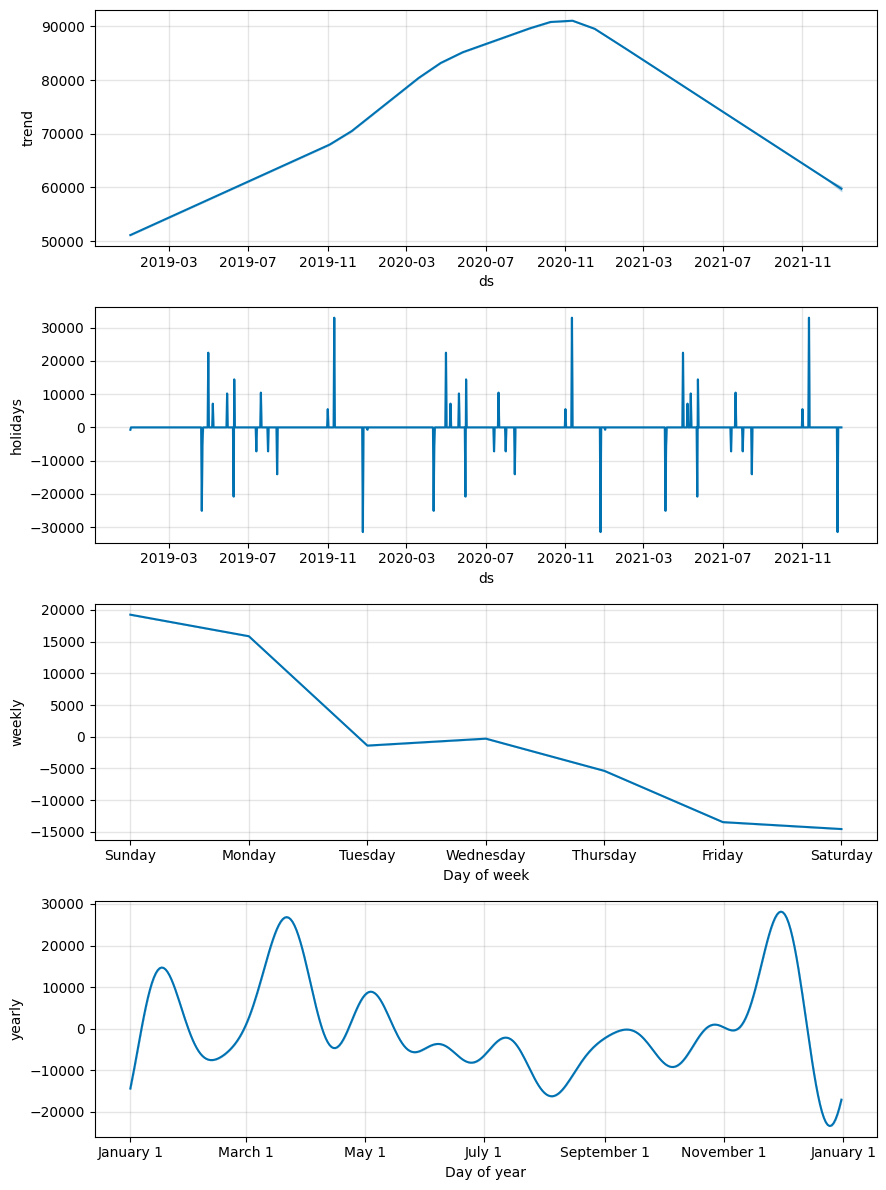

In [41]:
result_custom.forecast.plot_components()



*   The trend clearly shows that sales rose in the period to 19 October and are now beginning to fall.
*   Public holidays play an important role in the forecasts.

*   Not all days are the same; Sundays are order days. The annual graph shows the annual seasonality of the data.